In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import tqdm
import optax
import flax.linen as nn
from flax.metrics import tensorboard
from jax_resnet import resnet
from functools import partial
import numpy as np

import pisco
import pisco.datasets
import tensorflow_datasets as tfds

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/local/home/flanusse/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Define our compressor
ResNet = partial(resnet.ResNet18, n_classes=2)

class NeuralCompressor(nn.Module):
  @nn.compact
  def __call__(self, x):
    return ResNet()(x)

In [3]:
# Random seed for sampling from posterior
seed = jax.random.PRNGKey(0)

# Let's instantiate and initialize the model
model = NeuralCompressor()
params = model.init(jax.random.PRNGKey(42), jnp.zeros(shape=[1, 224, 224, 3]))

# Define a scheduler for the leaerning rate
total_steps = 30_000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.001,
                  boundaries_and_scales={int(total_steps*0.3):0.2,
                                         int(total_steps*0.6):0.1,})

# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params)

summary_writer = tensorboard.SummaryWriter('logs/mse')

In [4]:
dset = tfds.load('pisco_lsst',split='train')
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(dset.take(100)):
  cutouts.append(entry['image'])
cutouts = np.stack(cutouts)
cutouts[isnan(cutouts)] = 0

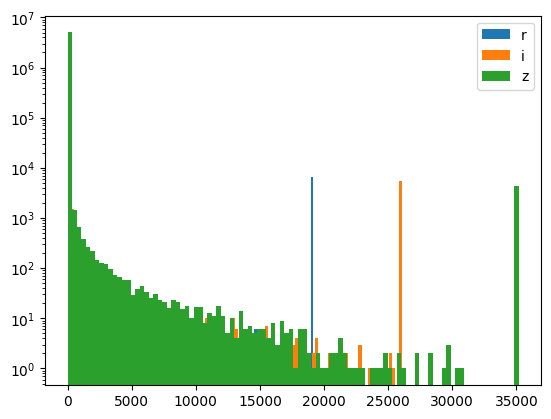

In [5]:
for i,b in enumerate(['r', 'i', 'z']):
  plt.hist(cutouts[...,i].flatten(),100, label=b);
plt.legend()
plt.yscale('log')

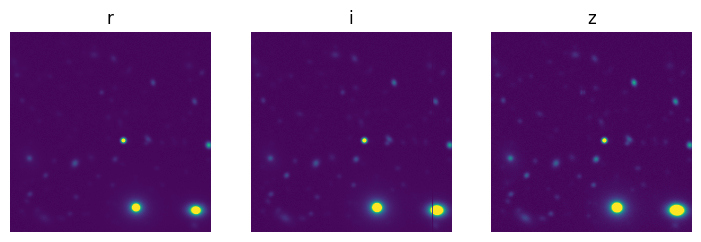

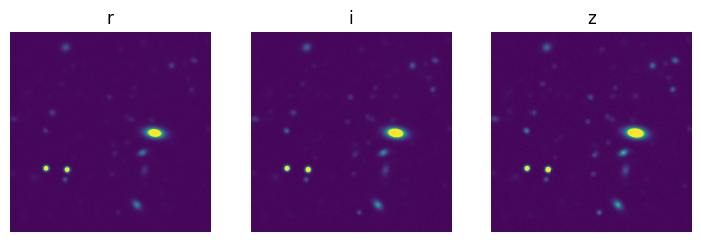

In [6]:
plt.figure(figsize=(15,3))
for i,b in enumerate(['r', 'i', 'z']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[0,:,:,i],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')

plt.figure(figsize=(15,3))
for i,b in enumerate(['r', 'i', 'z']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[1,:,:,i],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')


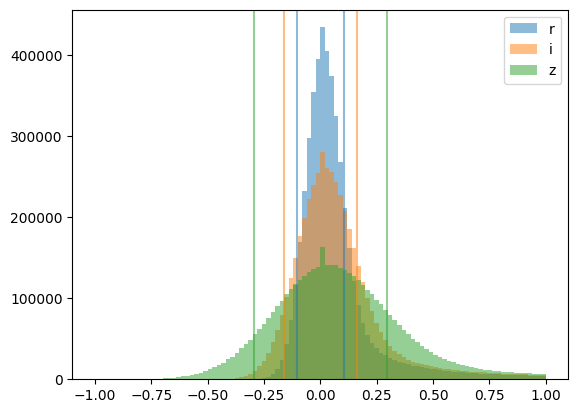

In [7]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['r', 'i', 'z']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5,range=[-1,1]);
  sigma = mad_std(cutouts[...,i].flatten())
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()

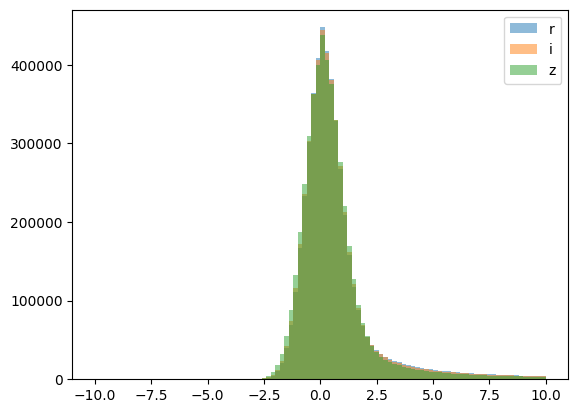

In [8]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['r', 'i', 'z']):
  plt.hist(cutouts[...,i].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
legend()

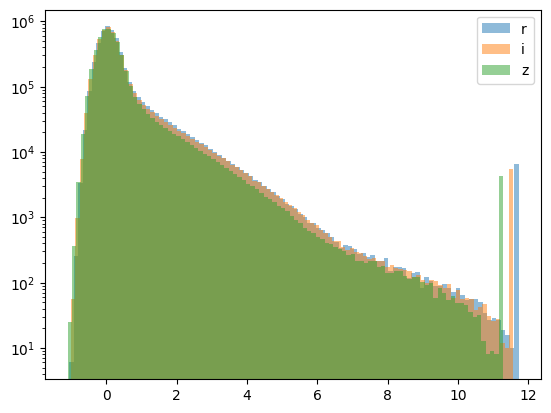

In [9]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
for i,b in enumerate(['r', 'i', 'z']):
  plt.hist(np.arcsinh(cutouts[...,i].flatten()/scaling[i]/3),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')

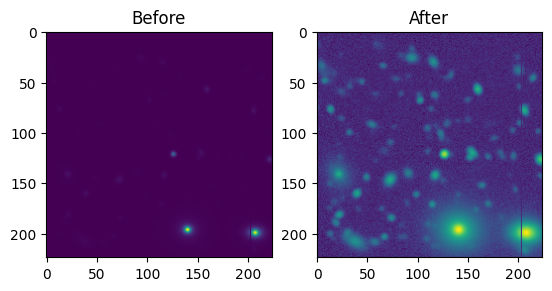

In [10]:
# we can have a look at individual postage stamps with or without this scaling
subplot(121)
imshow(cutouts[0,:,:,1]/scaling[1])
title('Before')
subplot(122)
imshow(np.arcsinh(cutouts[0,:,:,1]/scaling[1]/3))
title('After');

In [11]:
import tensorflow as tf
def preprocessing(example):
  def range_compression(img):
    return tf.clip_by_value(tf.math.asinh(img / tf.constant(scaling) / 3. ),-10,10)
  # Our preprocessing function only returns the postage stamps, and the specz
  return range_compression(example['image']), example['g']

In [12]:
batch_size = 64

# Load the data
dset = tfds.load('pisco_lsst',split='train[:90%]')
dset = dset.repeat()
dset = dset.shuffle(10000)
dset = dset.map(preprocessing)
dset = dset.batch(batch_size, drop_remainder=True)
dset = dset.prefetch(-1)
dset = dset.as_numpy_iterator()

In [16]:
dset_test = tfds.load('pisco_lsst',split='train[90%:]')
dset_test = dset_test.map(preprocessing)
dset_test = dset_test.batch(batch_size, drop_remainder=True)
dset_test = dset_test.prefetch(-1)
dset_test = dset_test.as_numpy_iterator()

In [13]:
# Define a simple MSE regression loss 
def loss_fn(params, batch):
    return jnp.mean(jnp.sum((model.apply(params, batch['x']) - batch['y'])**2,axis=-1))

@jax.jit
def update_model(params,  opt_state, batch):
  # Computes the gradients of the model
  loss, grads = jax.value_and_grad(loss_fn)(params, batch)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

In [14]:
%load_ext tensorboard
%tensorboard --logdir=.

In [ ]:
for i in tqdm.tqdm(range(total_steps)):
  batch = next(dset)
  key, seed  = jax.random.split(seed)
  batch = {'x': jnp.nan_to_num(batch[0]), 'y': batch[1]}
    
  # Apply the update function
  params, opt_state, loss = update_model(params, opt_state, batch)
  # Periodically exporting the value of the loss function, every 100 steps
  if i %10 ==0:
     summary_writer.scalar('train_loss', loss, i)
     summary_writer.scalar('learning_rate', lr_scheduler(i), i)

  4%|▎         | 1060/30000 [01:33<46:18, 10.41it/s]  

In [30]:
# Applying the model
batch = next(dset_test)

In [31]:
preds = model.apply(params, jnp.nan_to_num(batch[0]))

In [32]:
truth = batch[1]

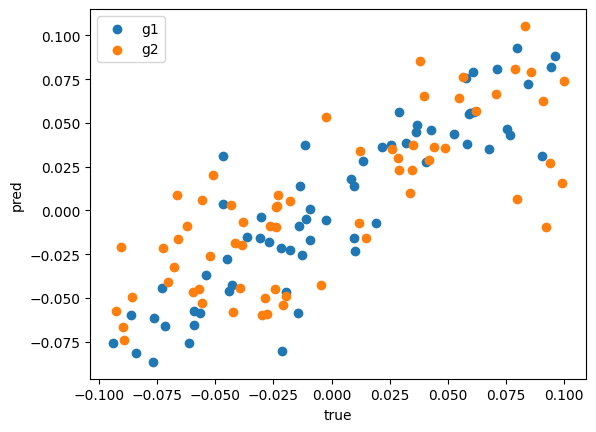

In [33]:
scatter(truth[:,0], preds[:,0], label='g1')
scatter(truth[:,1], preds[:,1], label='g2')
xlabel('true')
ylabel('pred')
legend()

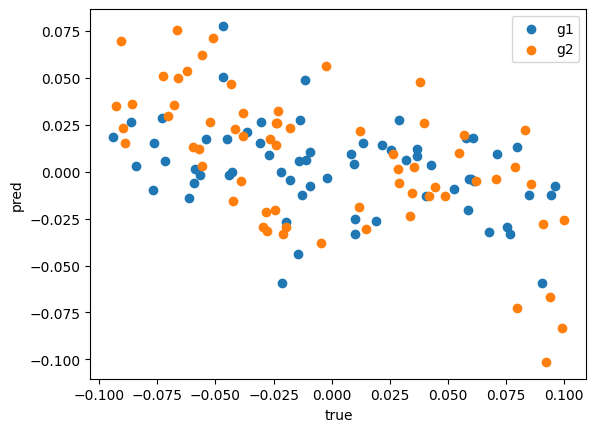

In [34]:
scatter(truth[:,0], preds[:,0] - truth[:,0], label='g1')
scatter(truth[:,1], preds[:,1] - truth[:,1], label='g2')
xlabel('true')
ylabel('pred')
legend()

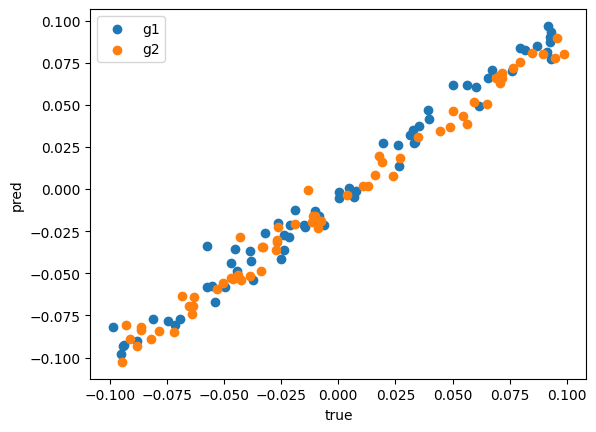

In [29]:
scatter(truth[:,0], preds[:,0], label='g1')
scatter(truth[:,1], preds[:,1], label='g2')
xlabel('true')
ylabel('pred')
legend()